In [56]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

The goal here is to predict which previously purchased products will be in a user’s next order.

# Overview

In [57]:
aisles = pd.read_csv('../input/instacart-market-basket-analysis/aisles.csv')
depts = pd.read_csv('../input/instacart-market-basket-analysis/departments.csv')
orders_prior = pd.read_csv('../input/instacart-market-basket-analysis/order_products__prior.csv')
orders_train = pd.read_csv('../input/instacart-market-basket-analysis/order_products__train.csv')
orders = pd.read_csv('../input/instacart-market-basket-analysis/orders.csv')
products = pd.read_csv('../input/instacart-market-basket-analysis/products.csv')

Let's start by looking at each of the inputs: their contents and sizes.

In [58]:
aisles.tail(3)

,aisle_id,aisle
131,132,beauty
132,133,muscles joints pain relief
133,134,specialty wines champagnes


In [59]:
depts.tail(3)

,department_id,department
18,19,snacks
19,20,deli
20,21,missing


In [60]:
orders_prior.tail(3)

,order_id,product_id,add_to_cart_order,reordered
32434486,3421083,4600,8,0
32434487,3421083,24852,9,1
32434488,3421083,5020,10,1


In [61]:
orders_train.tail(3)

,order_id,product_id,add_to_cart_order,reordered
1384614,3421070,35951,1,1
1384615,3421070,16953,2,1
1384616,3421070,4724,3,1


In [62]:
orders.tail(3)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
3421080,626363,206209,prior,12,1,12,18.0
3421081,2977660,206209,prior,13,1,12,7.0
3421082,272231,206209,train,14,6,14,30.0


In [63]:
products.tail(3)

,product_id,product_name,aisle_id,department_id
49685,49686,Artisan Baguette,112,3
49686,49687,Smartblend Healthy Metabolism Dry Cat Food,41,8
49687,49688,Fresh Foaming Cleanser,73,11


# Orders

Orders is clearly the most important of the inputs and contains the most information to digest. It has 3421083 rows and 7 columns. Let's look at it in more detail.

Text(0, 0.5, 'No. of orders')

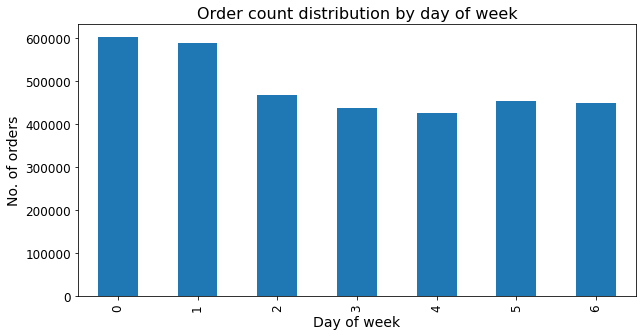

In [64]:
ax = orders['order_dow'].value_counts(sort=False).plot(kind='bar', figsize=(10,5), fontsize=12)
ax.set_title('Order count distribution by day of week',fontsize=16)
ax.set_xlabel('Day of week', fontsize=14)
ax.set_ylabel('No. of orders', fontsize=14)

It's not mentioned explicitly, but I assumed 0 to mean Sunday, 1 Monday and so on. I expected the number of orders to be highest on weekends, but judging from the plot above, I'm confused if the orders are highest on Sunday and Monday (since it is online ordering) or if 0 refers to Saturday in this case. I have to check further on this.

Text(0, 0.5, 'No. of orders')

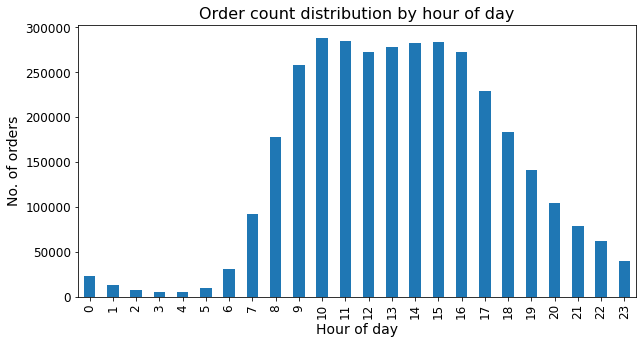

In [65]:
ax = orders['order_hour_of_day'].value_counts(sort=False).plot(kind='bar', figsize=(10,5), fontsize=12)
ax.set_title('Order count distribution by hour of day',fontsize=16)
ax.set_xlabel('Hour of day', fontsize=14)
ax.set_ylabel('No. of orders', fontsize=14)

This is an expected distribution. Most of the orders are in the daytime while ordering at night is still possible since Instacart is an online service.

Text(0, 0.5, 'Frequency')

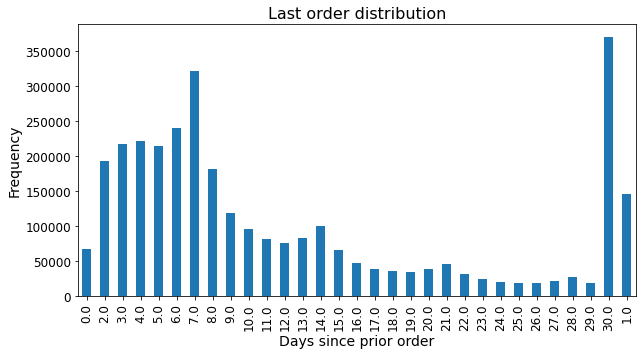

In [66]:
ax = orders['days_since_prior_order'].value_counts(sort=False).plot(kind='bar', figsize=(10,5), fontsize=12)
ax.set_title('Last order distribution',fontsize=16)
ax.set_xlabel('Days since prior order', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)

We see that most of the customers order 7 and 30 days from their last order. A simple and possibly accurate way to interpret this distribution is to say that most people order groceries once a week or once a month in bulk.

The products contained in an order are present in orders_prior and orders_train. My understanding after reading https://tech.instacart.com/3-million-instacart-orders-open-sourced-d40d29ead6f2 is that since the goal is to predict the products in an order, the last order of a user is separated out from the previous orders. These previous orders are in orders_prior. orders_train is used as training data for the model. There are also some orders left out which can be used as a test set for predictions. This test test can be fetched from the main orders df since it contains the eval_set column.

In [67]:
orders['eval_set'].value_counts()

prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64

In [68]:
eval_set_user_counts = orders.drop_duplicates(subset=['user_id', 'eval_set'])['eval_set'].value_counts()
eval_set_user_counts

prior    206209
train    131209
test      75000
Name: eval_set, dtype: int64

In [69]:
# No. of users
len(orders['user_id'].unique())

206209

In [70]:
eval_set_user_counts['train'] + eval_set_user_counts['test']

206209

In [71]:
prior_orders = orders.loc[orders['eval_set'] == 'prior']
prior_orders['order_number'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [72]:
train_set = orders.loc[orders['eval_set'] == 'train']
test_set = orders.loc[orders['eval_set'] == 'test']

In [73]:
train_set['order_number'].sort_values().unique()

array([  4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,
        17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,
        30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,
        43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
        56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,
        69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,
        82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,
        95,  96,  97,  98,  99, 100])

In [74]:
test_set['order_number'].sort_values().unique()

array([  4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,
        17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,
        30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,
        43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
        56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,
        69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,
        82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,
        95,  96,  97,  98,  99, 100])

From the above snippets, we see that of the total 206209 users, their last orders have been split into train and test eval_sets

Text(0, 0.5, 'No. of orders')

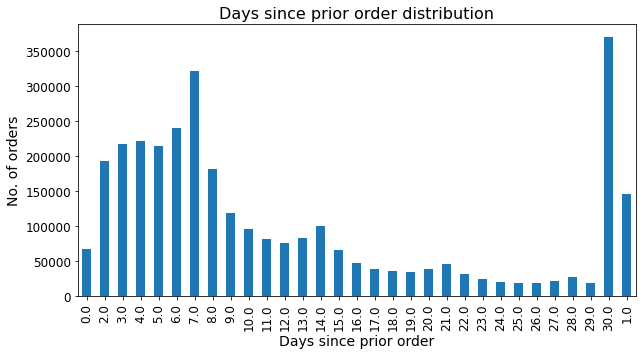

In [75]:
ax = orders['days_since_prior_order'].value_counts(sort=False).plot(kind='bar', figsize=(10,5), fontsize=12)
ax.set_title('Days since prior order distribution',fontsize=16)
ax.set_xlabel('Days since prior order', fontsize=14)
ax.set_ylabel('No. of orders', fontsize=14)

# Products
Now let's look at products

In [76]:
products.shape

(49688, 4)

Text(0, 0.5, 'No. of orders with that many products')

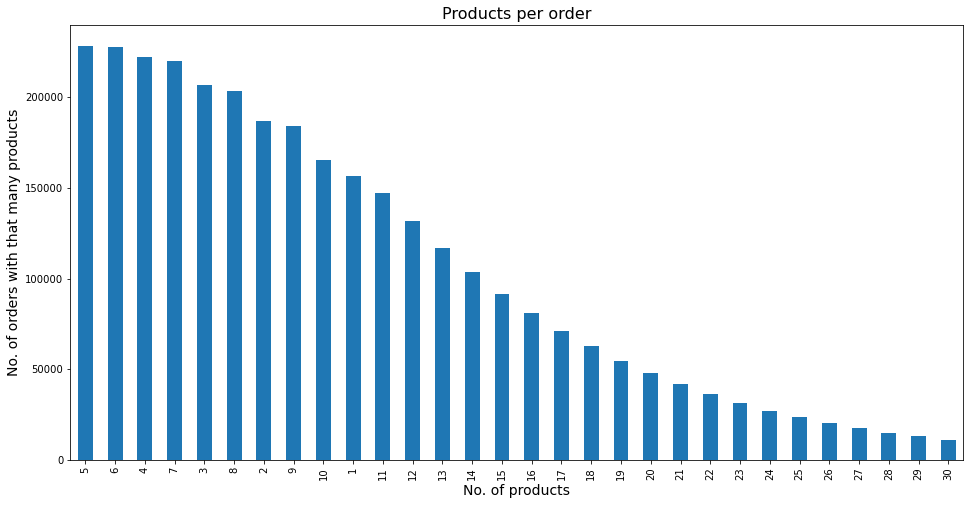

In [77]:
ax = orders_prior.groupby('order_id')['add_to_cart_order'].max().value_counts().head(30).plot(kind='bar', figsize=(16,8), fontsize=10)
ax.set_title('Products per order',fontsize=16)
ax.set_xlabel('No. of products', fontsize=14)
ax.set_ylabel('No. of orders with that many products', fontsize=14)

In [78]:
product_details = pd.merge(products, aisles, on=['aisle_id'], how='inner')
product_details = pd.merge(product_details, depts, on=['department_id'], how='inner')
product_details = product_details.drop(columns=['aisle_id', 'department_id'])
product_details.tail()

,product_id,product_name,aisle,department
49683,22827,Organic Black Mission Figs,bulk dried fruits vegetables,bulk
49684,28655,Crystallized Ginger Chunks,bulk dried fruits vegetables,bulk
49685,30365,Vegetable Chips,bulk dried fruits vegetables,bulk
49686,38007,Naturally Sweet Plantain Chips,bulk dried fruits vegetables,bulk
49687,48778,"Fit Super A Juice, Cold Pressed, Carrot/Apple/...",bulk dried fruits vegetables,bulk


In [79]:
order_details = pd.merge(orders_prior, product_details, on=['product_id'], how='inner').drop(columns=['product_id'])
order_details = pd.merge(order_details, orders, on=['order_id'], how='inner')
order_details.tail()

,order_id,add_to_cart_order,reordered,product_name,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
32434484,1666202,1,0,Indian Wells Merlot,red wines,alcohol,189140,prior,2,3,11,20.0
32434485,1699504,1,0,Fish Oil 1000 mg+300 mg Omega-3 Softgels,vitamins supplements,personal care,182854,prior,10,5,15,2.0
32434486,2666238,1,0,Disinfecting Toilet Bowl Cleaner,cleaning products,household,51836,prior,12,0,18,0.0
32434487,2770035,1,0,"Indoor & Outdoor Allergies, Allergy & Congesti...",cold flu allergy,personal care,37237,prior,50,6,16,2.0
32434488,3326955,1,0,Cotes De Provence Rose,other,other,132609,prior,7,3,15,2.0


In [81]:
len(order_details['department'].unique())

21

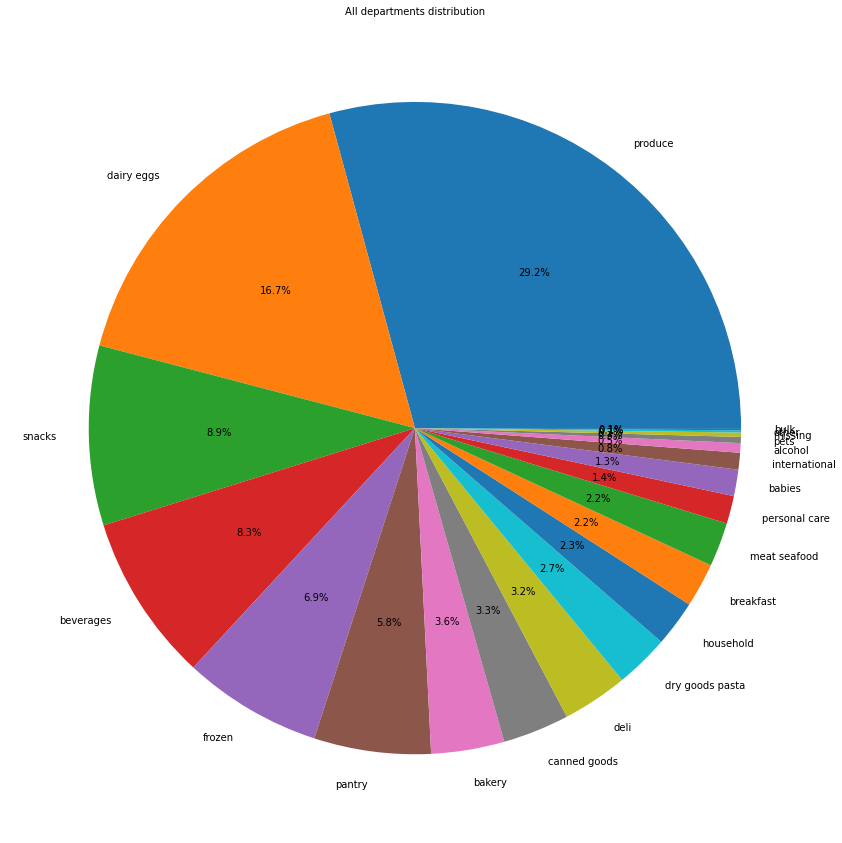

In [82]:
plt.figure(figsize=(20,15))
temp = order_details['department'].value_counts()
labels = (np.array(temp.index))
sizes = (np.array((temp / temp.sum())*100))
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title("All departments distribution", fontsize=10)
plt.show()
temp=None
sizes=None

Treemap of departments and aisles in them. The sizes indicate number of products in each.

In [101]:
import plotly.express as px
fig = px.treemap(product_details.groupby(['department', 'aisle']).agg({'product_name':'count'}).reset_index(), path=['department', 'aisle'], values='product_name')
fig.show()

In [84]:
len(order_details['aisle'].unique())

134

Text(0, 0.5, 'No. of orders from this aisle')

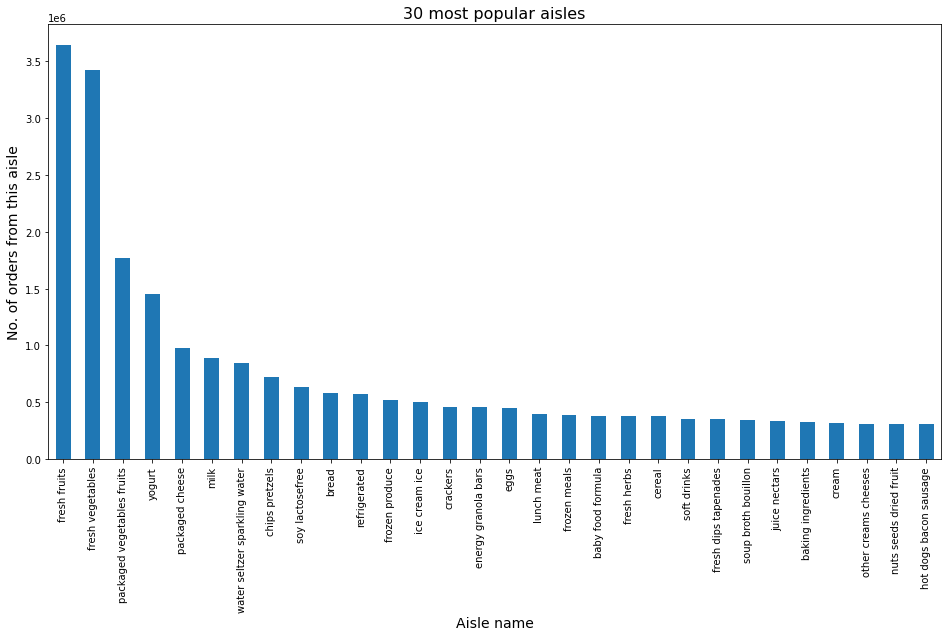

In [85]:
ax = order_details['aisle'].value_counts(sort=True).head(30).plot(kind='bar', figsize=(16,8), fontsize=10)
ax.set_title('30 most popular aisles',fontsize=16)
ax.set_xlabel('Aisle name', fontsize=14)
ax.set_ylabel('No. of orders from this aisle', fontsize=14)

In [86]:
len(order_details['product_name'].unique())

49677

Text(0, 0.5, 'No. of times ordered')

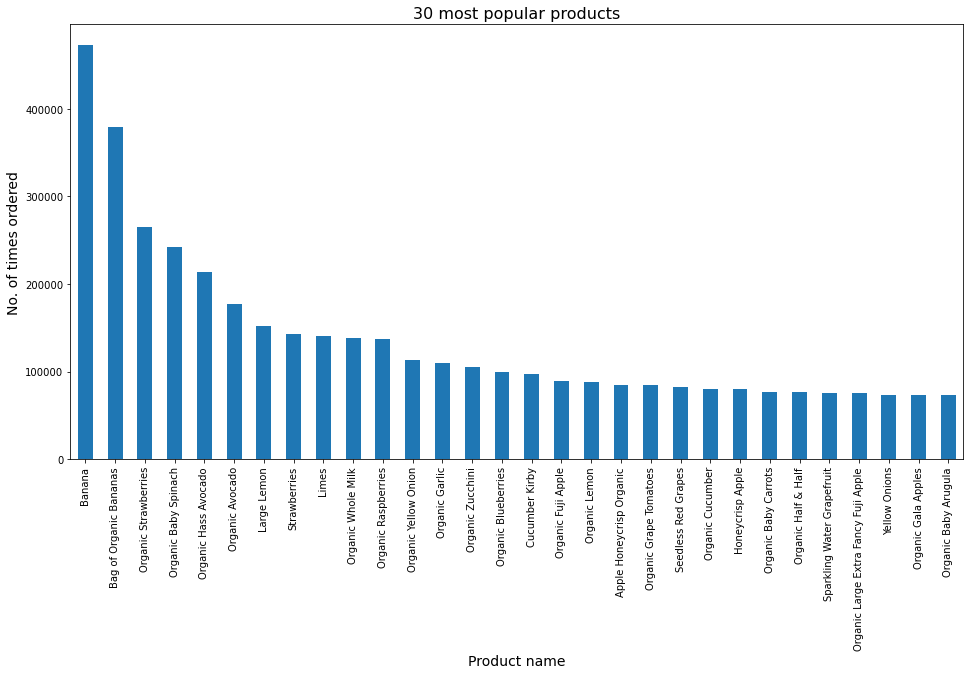

In [87]:
ax = order_details['product_name'].value_counts(sort=True).head(30).plot(kind='bar', figsize=(16,8), fontsize=10)
ax.set_title('30 most popular products',fontsize=16)
ax.set_xlabel('Product name', fontsize=14)
ax.set_ylabel('No. of times ordered', fontsize=14)

In [88]:
# prodcts ordered by user 1
order_details.loc[order_details['user_id'] == 1]['product_name'].value_counts(sort=True)


Original Beef Jerky                        10
Soda                                       10
Pistachios                                  9
Organic String Cheese                       8
Zero Calorie Cola                           3
Cinnamon Toast Crunch                       3
Bag of Organic Bananas                      2
XL Pick-A-Size Paper Towel Rolls            2
Aged White Cheddar Popcorn                  2
Organic Half & Half                         2
Milk Chocolate Almonds                      1
Organic Unsweetened Vanilla Almond Milk     1
Organic Unsweetened Almond Milk             1
0% Greek Strained Yogurt                    1
Creamy Almond Butter                        1
Honeycrisp Apples                           1
Organic Fuji Apples                         1
Bartlett Pears                              1
Name: product_name, dtype: int64

# Reorder data

The information about previous reorders could be very useful for predicting the next order of a customer. So let's look at that more closely now.

Let's look at the reorder trends of products

Text(0, 0.5, 'No. of times reordered')

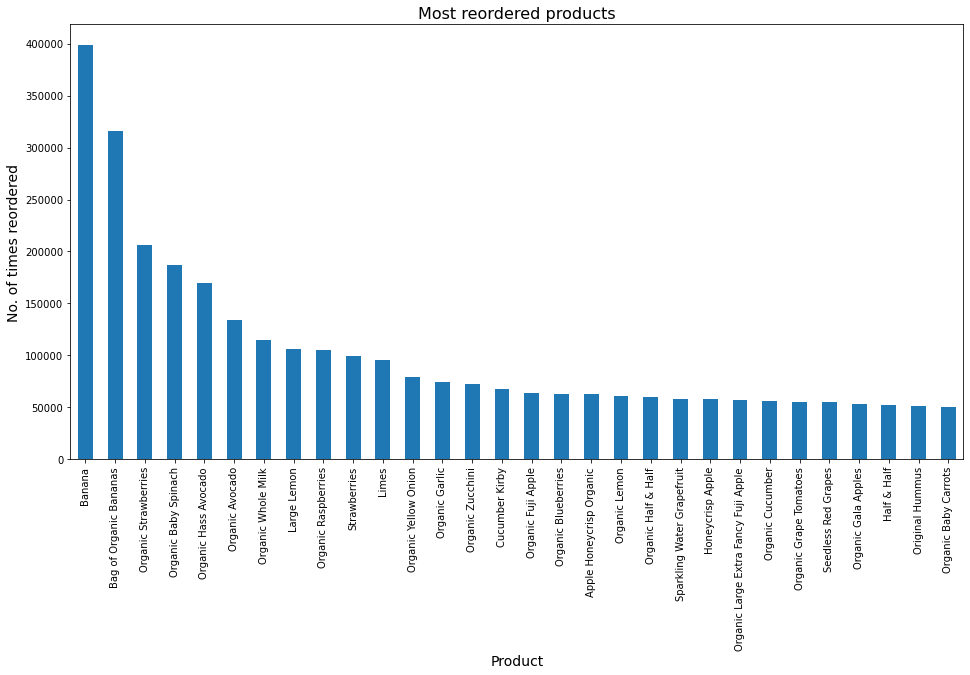

In [89]:
ax = order_details.loc[order_details['reordered'] == 1]['product_name'].value_counts(sort=True).head(30).plot(kind='bar', figsize=(16,8), fontsize=10)
ax.set_title('Most reordered products',fontsize=16)
ax.set_xlabel('Product', fontsize=14)
ax.set_ylabel('No. of times reordered', fontsize=14)

No surprises here

In [90]:
per = (orders_prior['reordered'].sum()/orders_prior.shape[0]).round(3)
f'The percentage of total reordered products in the prior orders set is {per*100} %'

'The percentage of total reordered products in the prior orders set is 59.0 %'

In [91]:
grouped = orders_prior.groupby('order_id')['reordered'].sum().reset_index()
reorders = grouped.loc[grouped['reordered'] > 0]
per = round((reorders.shape[0]/grouped.shape[0]), 3)
f'The percentage of orders in the prior orders set with reordered items is {per*100} %'

'The percentage of orders in the prior orders set with reordered items is 87.9 %'

# Hypothesis Generation

Let's try to cluster our pool of customers with the data we have available. Note that these could very well be entirely off the mark.

In [92]:
len(order_details['user_id'].unique())

206209

Let's try to validate some assumptions about customers using the given data. First let's look at departments. 

In [93]:
order_details['department'].unique().tolist()

['dairy eggs',
 'produce',
 'pantry',
 'meat seafood',
 'frozen',
 'beverages',
 'snacks',
 'breakfast',
 'deli',
 'dry goods pasta',
 'international',
 'canned goods',
 'household',
 'personal care',
 'other',
 'missing',
 'bakery',
 'pets',
 'bulk',
 'babies',
 'alcohol']

Treemaps of departments. The sizes indicate the sales.

In [ ]:
fig = px.treemap(order_details.groupby(['department', 'aisle']).agg({'product_name':'count'}).reset_index(), path=['department', 'aisle'], values='product_name')
fig.show()

In [94]:
fig = px.treemap(personal_care_dept.groupby(['aisle']).agg({'product_name':'count'}).reset_index(), path=['aisle'], values='product_name')
fig.show()

Male and female count.

In [95]:
# Possible lower bound for female customers
len(personal_care_dept.loc[personal_care_dept['aisle'] == 'feminine care']['user_id'].unique())

9197

Customers with babies

In [96]:
# order_details.loc[order_details['department'] == 'babies']['product_name'].unique().tolist()

In [97]:
len(order_details.loc[order_details['department'] == 'babies']['user_id'].unique())

33730

Age of customers

In [98]:
# Older customers
len(personal_care_dept.loc[personal_care_dept['aisle'] == 'muscles joints pain relief']['user_id'].unique())

10365

Customers with pets

In [99]:
len(order_details.loc[order_details['department'] == 'pets']['user_id'].unique())

14986

Health conscious customers

In [100]:
len(personal_care_dept.loc[personal_care_dept['aisle'] == 'protein meal replacements']['user_id'].unique())

13046